In [1]:
import time
import matplotlib.pyplot as plt

# River imports
from river.tree import HoeffdingTreeRegressor, HoeffdingAdaptiveTreeRegressor
from river.datasets import synth, Elec2
from river.metrics import RMSE
from river.tree.splitter import FadingQOSplitter, QOSplitter

def evaluate_and_plot_all_metrics(dataset, model, metric, print_every=1000):
    """
    Executa a avaliação progressiva e captura métricas de performance e complexidade.
    Retorna dicionários com o histórico de cada métrica para plotagem.
    """
    metric = metric.clone()
    print(f"Evaluating {model.__class__.__name__}")

    # Dicionário para armazenar o histórico de todas as métricas
    history = {
        "steps": [],
        "performance": [],
        "n_nodes": [],
        "n_leaves": [],
        "height": [],
        "inference_time_us": [], # em microssegundos para melhor precisão
        "learning_time_us": [],
        "memory_usage": [],
    }

    for i, (x, y) in enumerate(dataset):
        # Medir tempo de inferência
        start_pred = time.perf_counter()
        y_pred = model.predict_one(x)
        end_pred = time.perf_counter()

        metric.update(y, y_pred)

        # Medir tempo de aprendizagem
        start_learn = time.perf_counter()
        model.learn_one(x, y)
        end_learn = time.perf_counter()

        if (i + 1) % print_every == 0:
            history["steps"].append(i + 1)
            history["performance"].append(metric.get())
            history["n_nodes"].append(getattr(model, 'n_nodes', 0))
            history["n_leaves"].append(getattr(model, 'n_leaves', 0))
            history["height"].append(getattr(model, 'height', 0))
            history["inference_time_us"].append((end_pred - start_pred) * 1_000_000)
            history["learning_time_us"].append((end_learn - start_learn) * 1_000_000),
            history["memory_usage"].append(getattr(model, '_raw_memory_usage', 0))

    print(f"Final {metric}: {metric.get():.6f}")
    return history

In [2]:
def get_datasets():
    """
    Retorna um dicionário de 'fábricas' de dataset.
    Cada item é uma função que, quando chamada, retorna um novo stream.
    """
    return {
        # "elec-2": lambda: Elec2(),
        # "planes2d": lambda: synth.Planes2D(seed=42),
        "friedman_drift_local": lambda: synth.ConceptDriftStream(
            stream=synth.FriedmanDrift(seed=42),
            drift_stream=synth.FriedmanDrift(seed=42, drift_type='lea'),
            seed=42, position=25000, width=5000
        ),
        # "hyperplane_drift": lambda: synth.ConceptDriftStream(
        #     stream=synth.Hyperplane(seed=42, n_features=10),
        #     drift_stream=synth.Hyperplane(seed=42, n_features=10, n_drift_features=5),
        #     seed=42, position=25000, width=5000
        # ),
        "friedman_drift_abrupt": lambda: synth.ConceptDriftStream(
            stream=synth.FriedmanDrift(seed=42),
            drift_stream=synth.FriedmanDrift(seed=42, drift_type='gra', position=(10_000, 30_000)),
            seed=42, width=5000
        ),
        "friedman_drift_abrupt-2": lambda: synth.ConceptDriftStream(
            stream=synth.FriedmanDrift(seed=1),
            drift_stream=synth.FriedmanDrift(seed=1, drift_type='gra', position=(15_000, 35_000)),
            seed=1, width=5000
        ),
        "friedman_drift_slow_abrupt": lambda: synth.ConceptDriftStream(
            stream=synth.FriedmanDrift(seed=42),
            drift_stream=synth.FriedmanDrift(seed=42, drift_type='gsg', position=(10_000, 30_000)),
            seed=42, width=5000
        ),
    }

def get_models():
    """Retorna um dicionário de modelos para avaliação."""
    return {
        'HTR-QO (Multi-way)': HoeffdingTreeRegressor(
            splitter=QOSplitter(allow_multiway_splits=True),
        ),
        # 'HTR-QO (Binary)': HoeffdingTreeRegressor(
        #     splitter=QOSplitter(allow_multiway_splits=False), grace_period=100
        # ),
        'HTR-F-QO (α=0.999)': HoeffdingTreeRegressor(
            splitter=FadingQOSplitter(alpha=0.999, allow_multiway_splits=True),
        ),
        'HTR-F-QO (α=0.990)': HoeffdingTreeRegressor(
            splitter=FadingQOSplitter(alpha=0.990, allow_multiway_splits=True),
        ),
        'HTR-F-QO (α=0.900)': HoeffdingTreeRegressor(
            splitter=FadingQOSplitter(alpha=0.900, allow_multiway_splits=True),
        ),
        'HATR (Adaptive)': HoeffdingAdaptiveTreeRegressor()
    }

--- Iniciando avaliação no dataset: FRIEDMAN_DRIFT_LOCAL ---

Avaliando modelo: HTR-QO (Multi-way)
Evaluating HoeffdingTreeRegressor
Final RMSE: 2.151857: 2.151857

Avaliando modelo: HTR-F-QO (α=0.999)
Evaluating HoeffdingTreeRegressor
Final RMSE: 2.017201: 2.017201

Avaliando modelo: HTR-F-QO (α=0.990)
Evaluating HoeffdingTreeRegressor
Final RMSE: 2.203732: 2.203732

Avaliando modelo: HTR-F-QO (α=0.900)
Evaluating HoeffdingTreeRegressor
Final RMSE: 2.113502: 2.113502

Avaliando modelo: HATR (Adaptive)
Evaluating HoeffdingAdaptiveTreeRegressor
Final RMSE: 2.541685: 2.541685


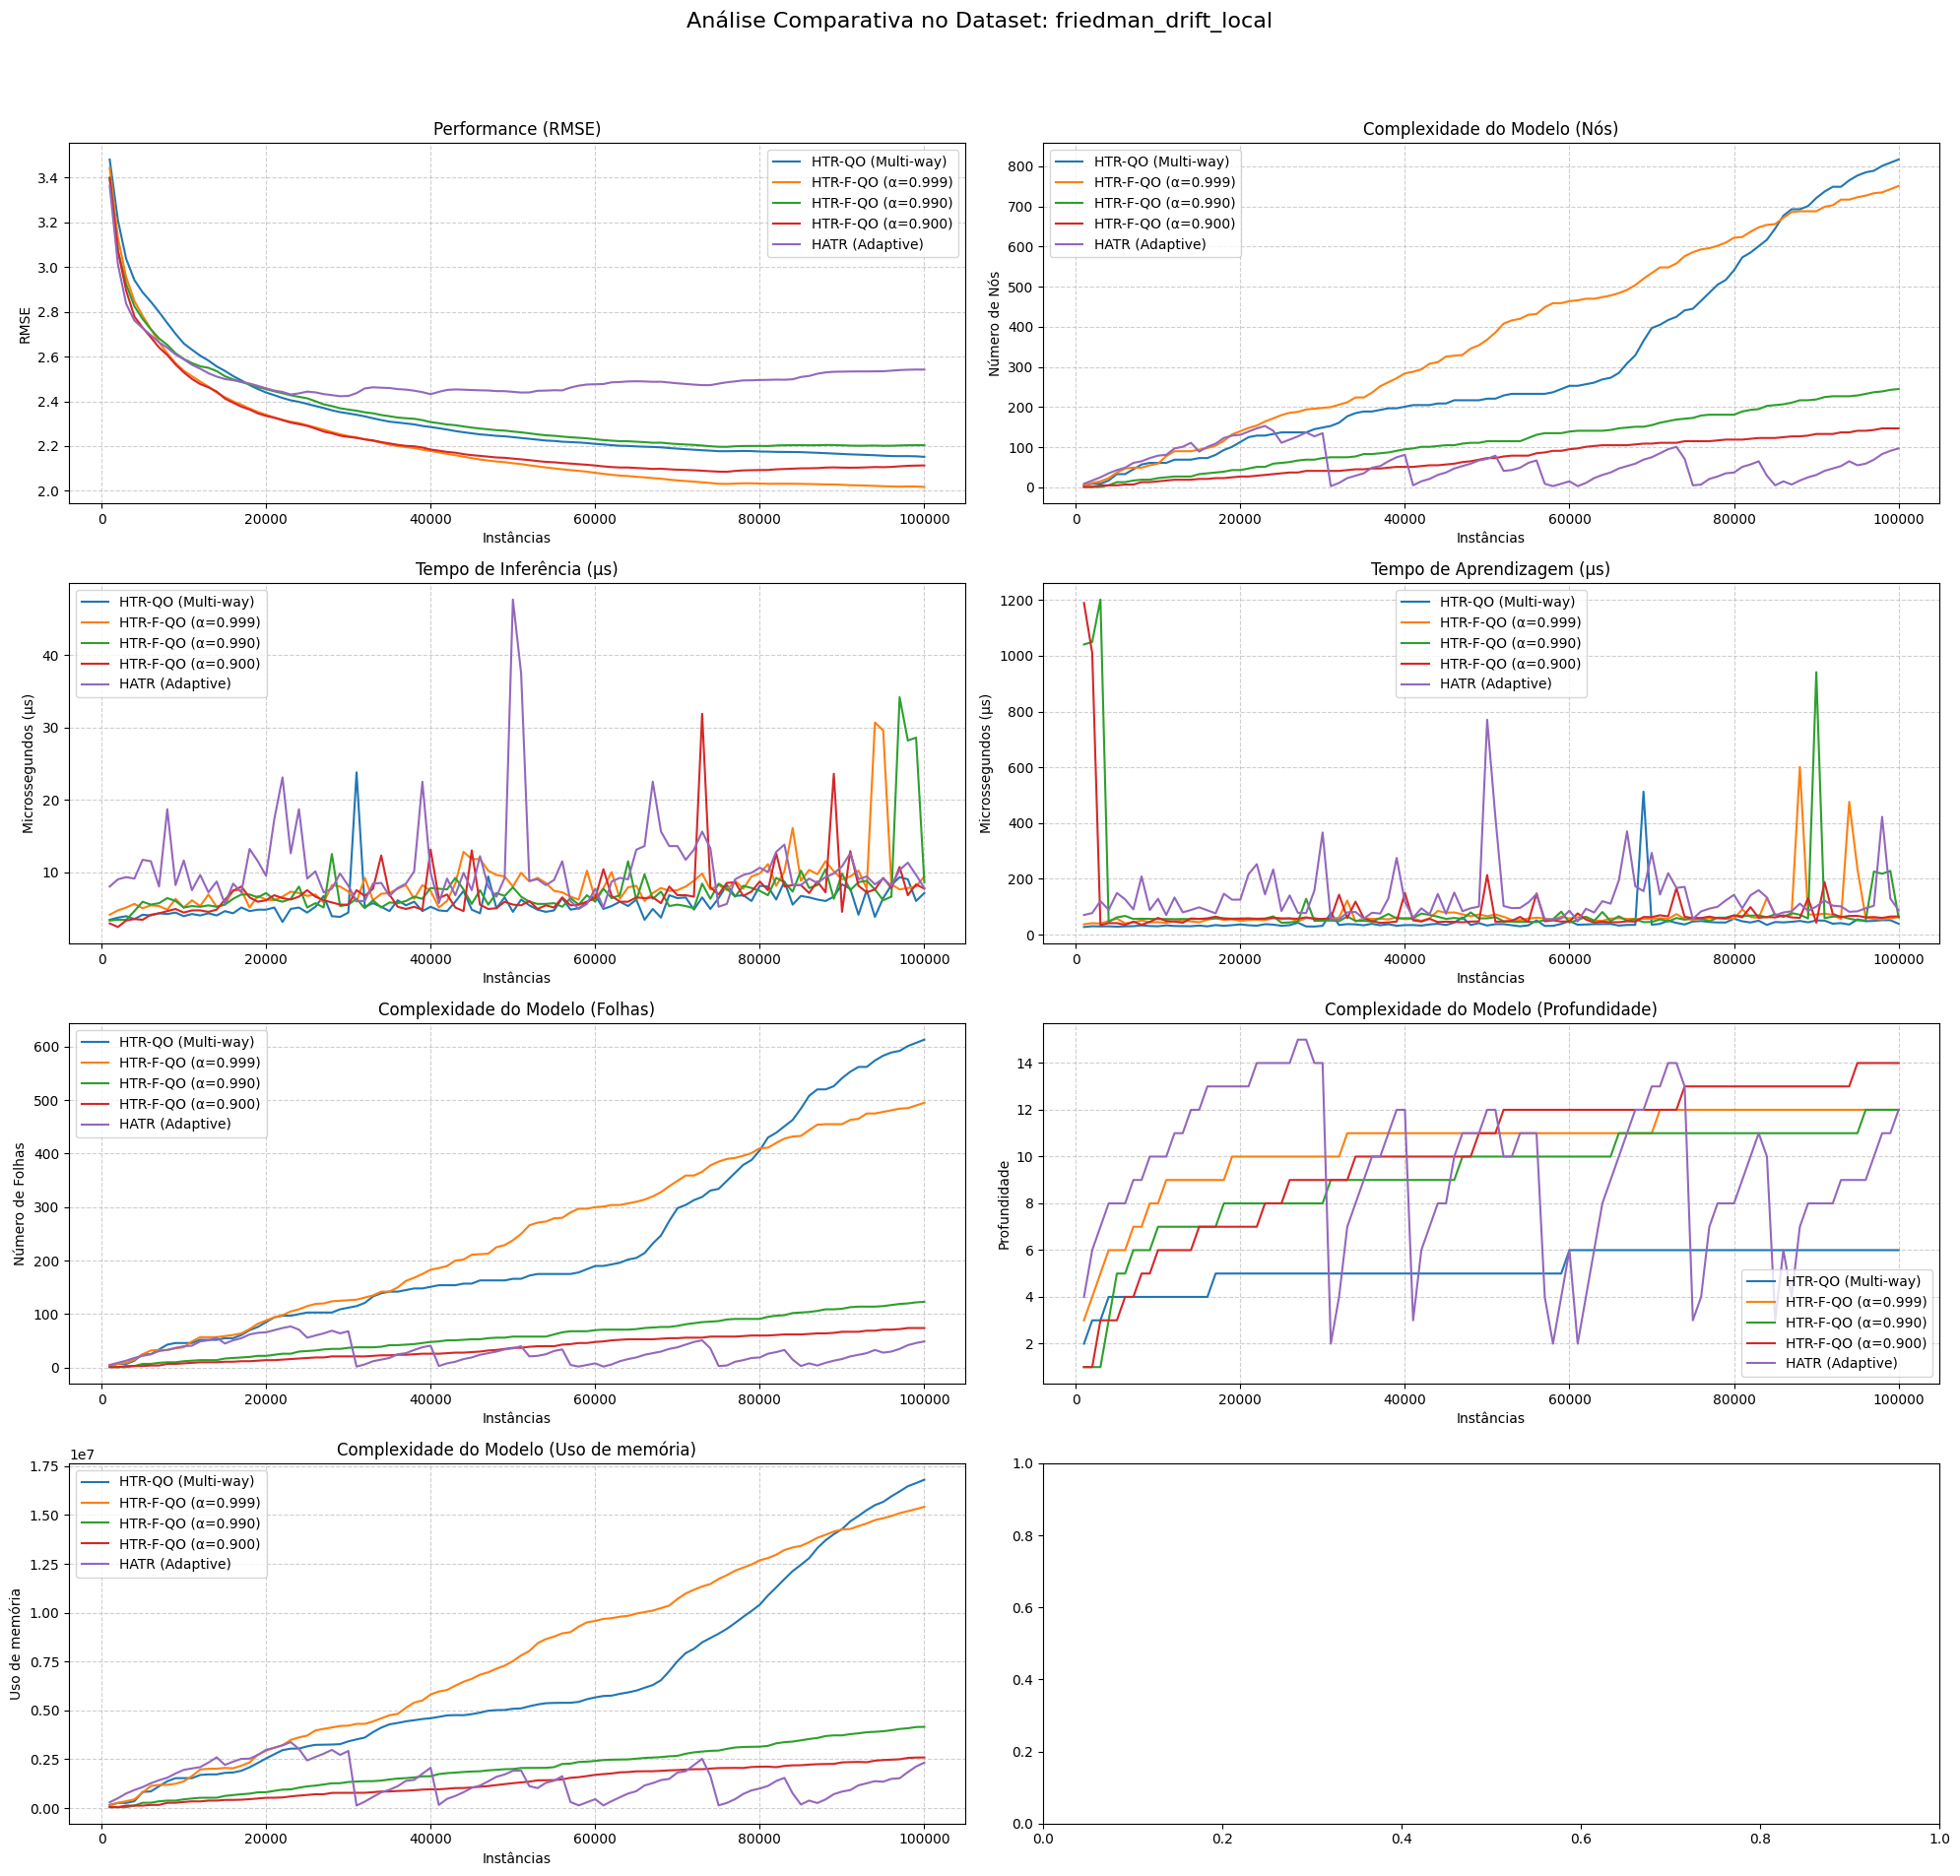

--------------------------------------------------
--- Iniciando avaliação no dataset: FRIEDMAN_DRIFT_ABRUPT ---

Avaliando modelo: HTR-QO (Multi-way)
Evaluating HoeffdingTreeRegressor
Final RMSE: 2.469499: 2.469499

Avaliando modelo: HTR-F-QO (α=0.999)
Evaluating HoeffdingTreeRegressor
Final RMSE: 2.479018: 2.479018

Avaliando modelo: HTR-F-QO (α=0.990)
Evaluating HoeffdingTreeRegressor
Final RMSE: 2.482436: 2.482436

Avaliando modelo: HTR-F-QO (α=0.900)
Evaluating HoeffdingTreeRegressor
Final RMSE: 2.400447: 2.400447

Avaliando modelo: HATR (Adaptive)
Evaluating HoeffdingAdaptiveTreeRegressor
Final RMSE: 2.468558: 2.468558


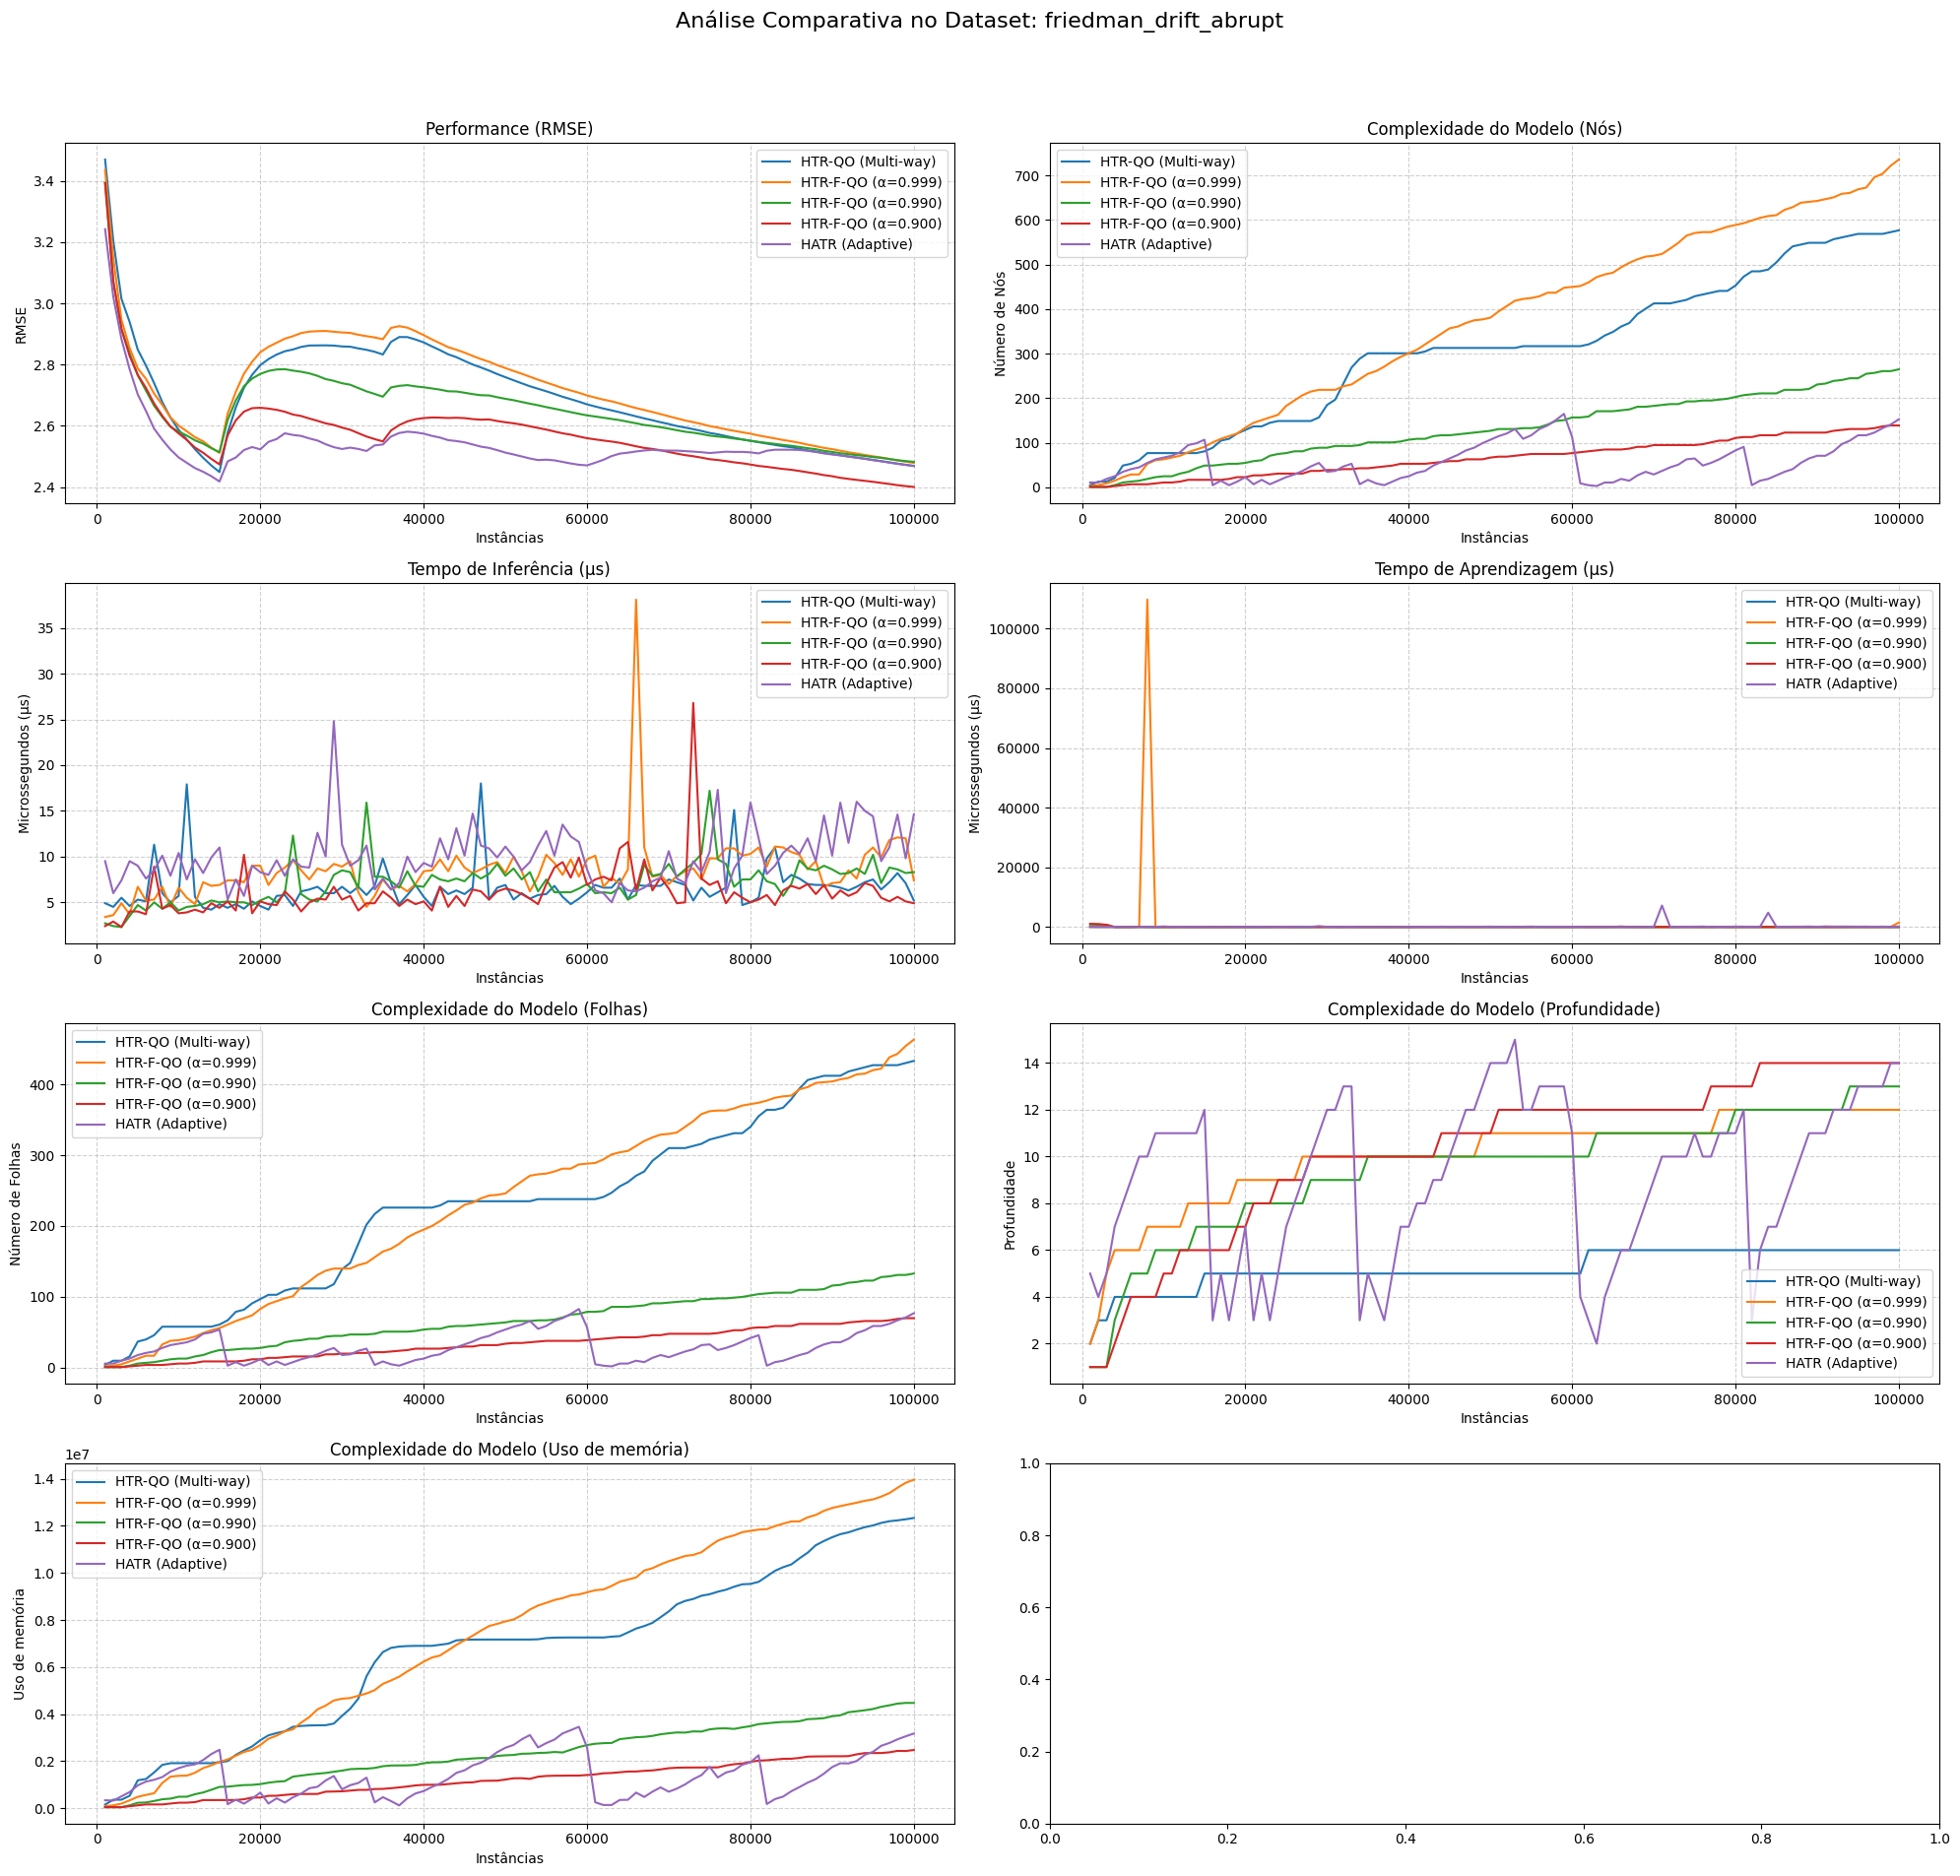

--------------------------------------------------
--- Iniciando avaliação no dataset: FRIEDMAN_DRIFT_ABRUPT-2 ---

Avaliando modelo: HTR-QO (Multi-way)
Evaluating HoeffdingTreeRegressor
Final RMSE: 2.503064: 2.503064

Avaliando modelo: HTR-F-QO (α=0.999)
Evaluating HoeffdingTreeRegressor
Final RMSE: 2.451677: 2.451677

Avaliando modelo: HTR-F-QO (α=0.990)
Evaluating HoeffdingTreeRegressor
Final RMSE: 2.456963: 2.456963

Avaliando modelo: HTR-F-QO (α=0.900)
Evaluating HoeffdingTreeRegressor
Final RMSE: 2.316383: 2.316383

Avaliando modelo: HATR (Adaptive)
Evaluating HoeffdingAdaptiveTreeRegressor
Final RMSE: 2.419201: 2.419201


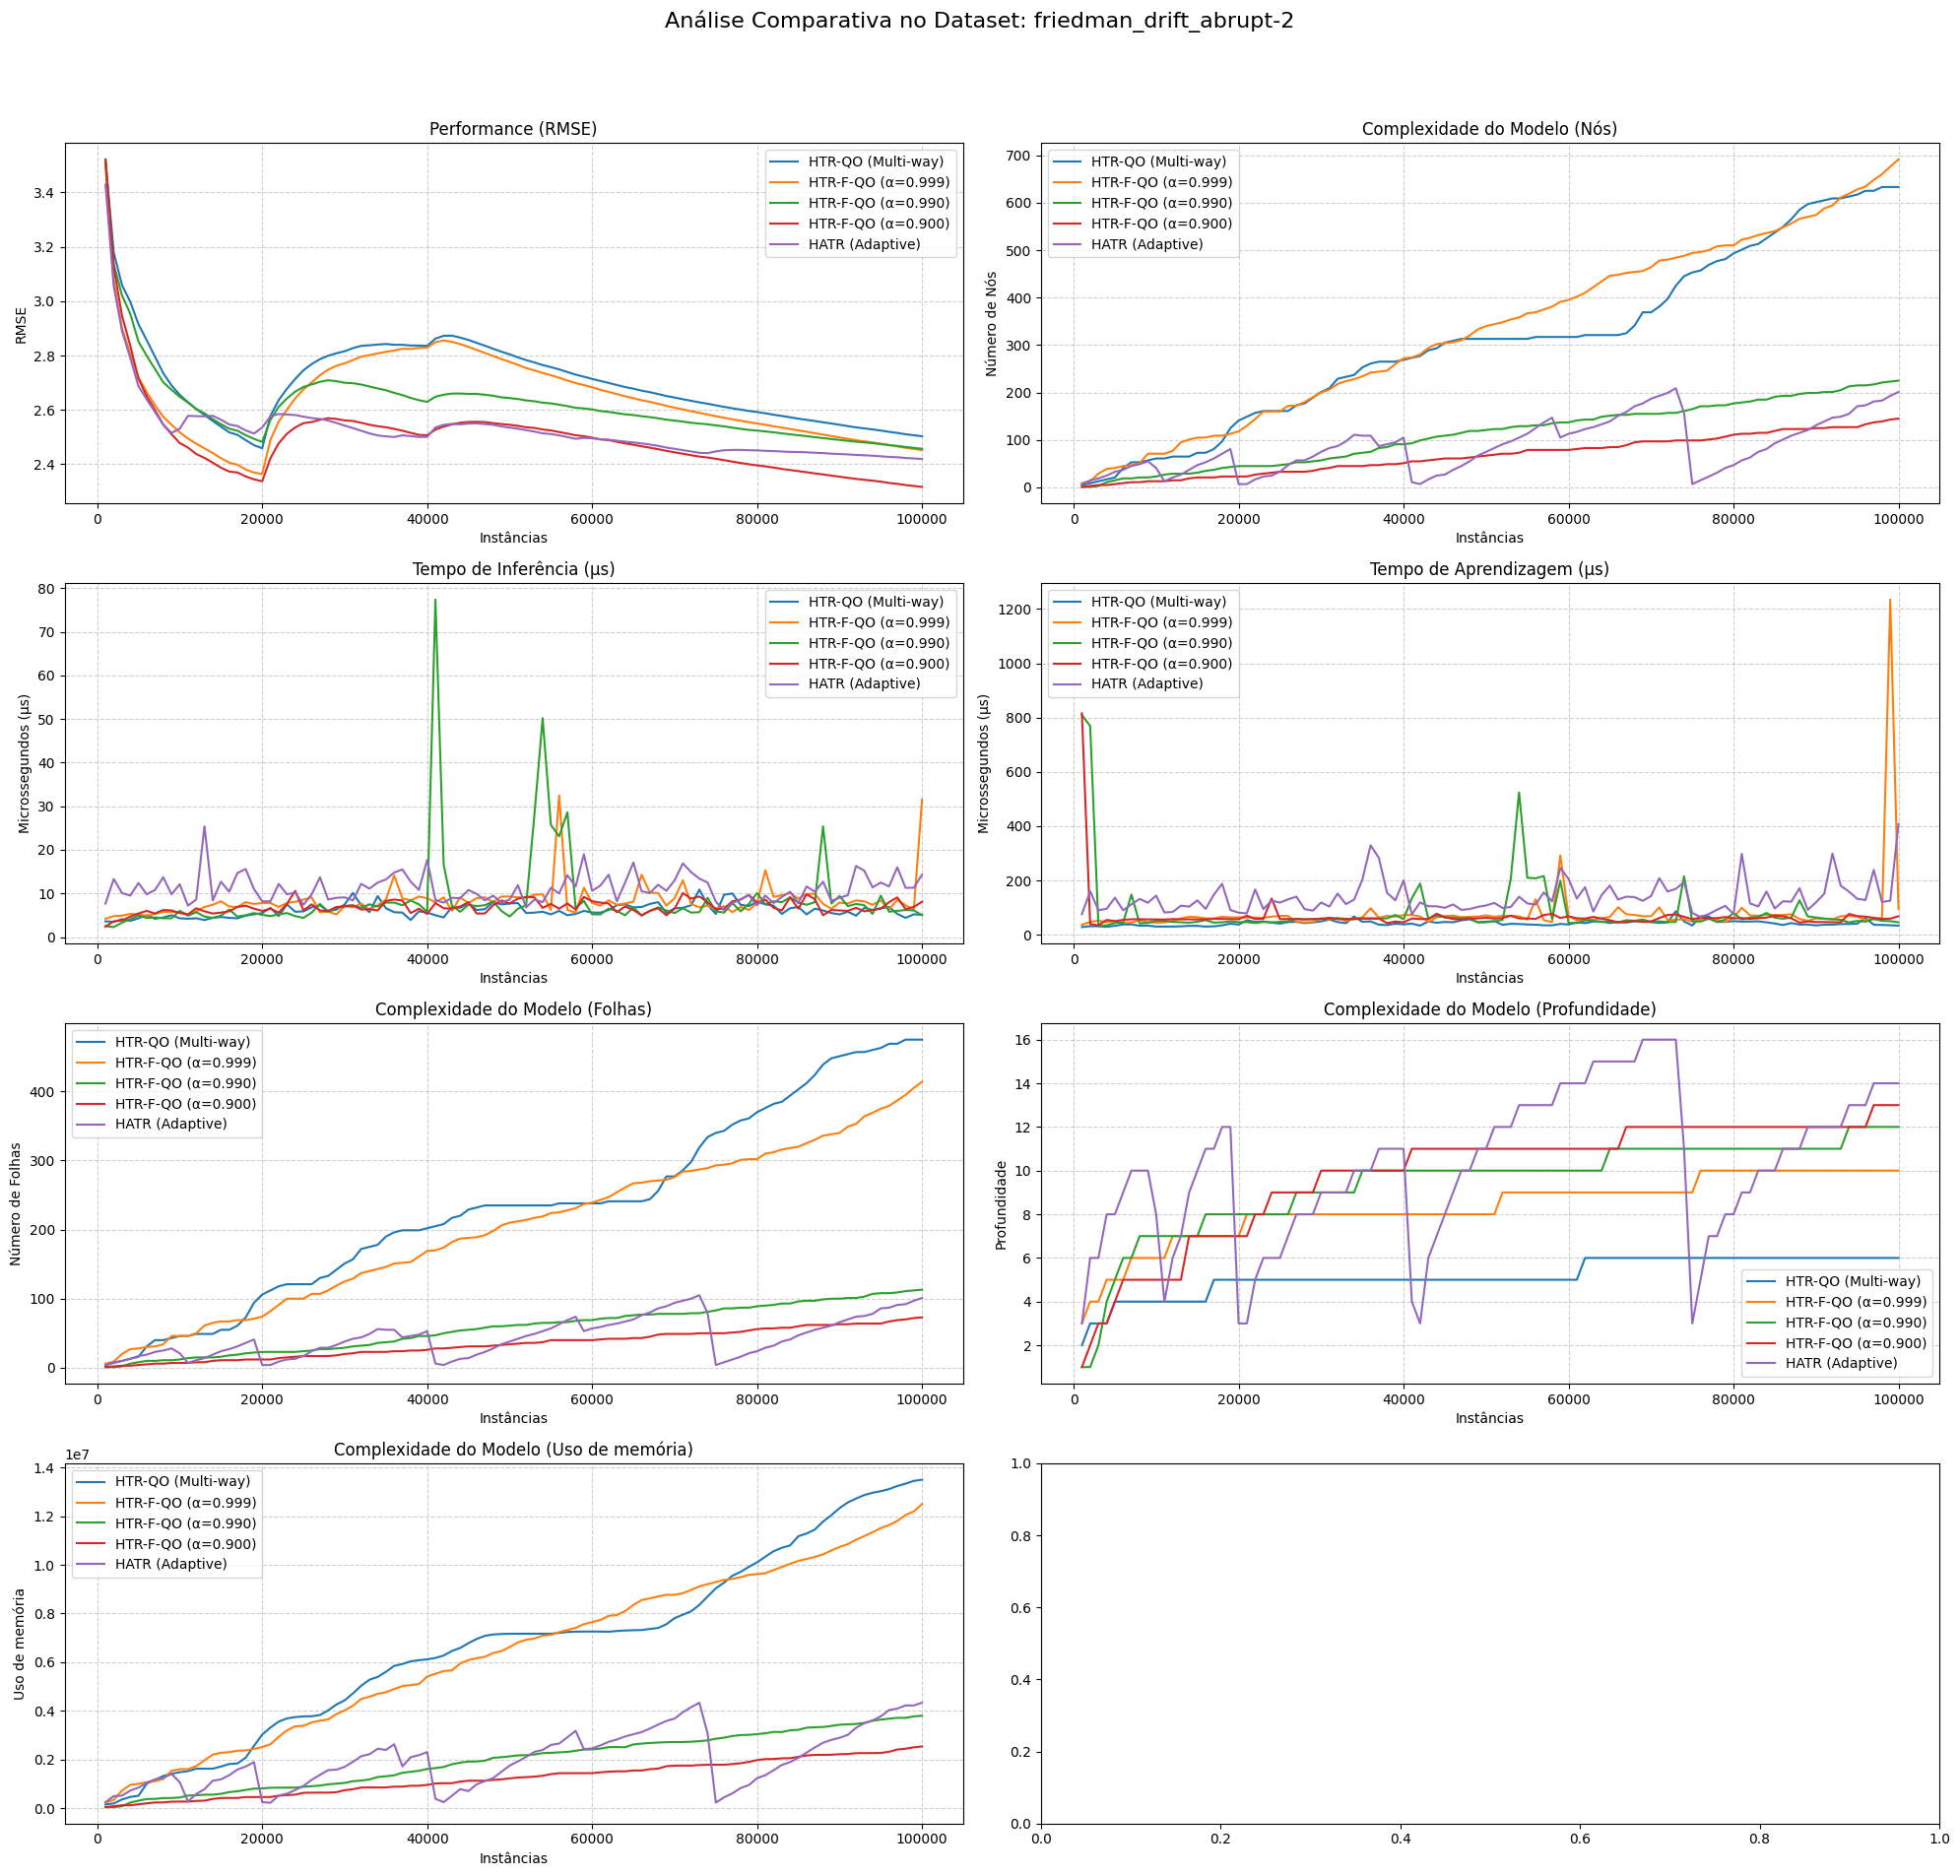

--------------------------------------------------
--- Iniciando avaliação no dataset: FRIEDMAN_DRIFT_SLOW_ABRUPT ---

Avaliando modelo: HTR-QO (Multi-way)
Evaluating HoeffdingTreeRegressor
Final RMSE: 2.690427: 2.690427

Avaliando modelo: HTR-F-QO (α=0.999)
Evaluating HoeffdingTreeRegressor
Final RMSE: 2.625565: 2.625565

Avaliando modelo: HTR-F-QO (α=0.990)
Evaluating HoeffdingTreeRegressor
Final RMSE: 2.562845: 2.562845

Avaliando modelo: HTR-F-QO (α=0.900)
Evaluating HoeffdingTreeRegressor
Final RMSE: 2.528007: 2.528007

Avaliando modelo: HATR (Adaptive)
Evaluating HoeffdingAdaptiveTreeRegressor
Final RMSE: 2.556296: 2.556296


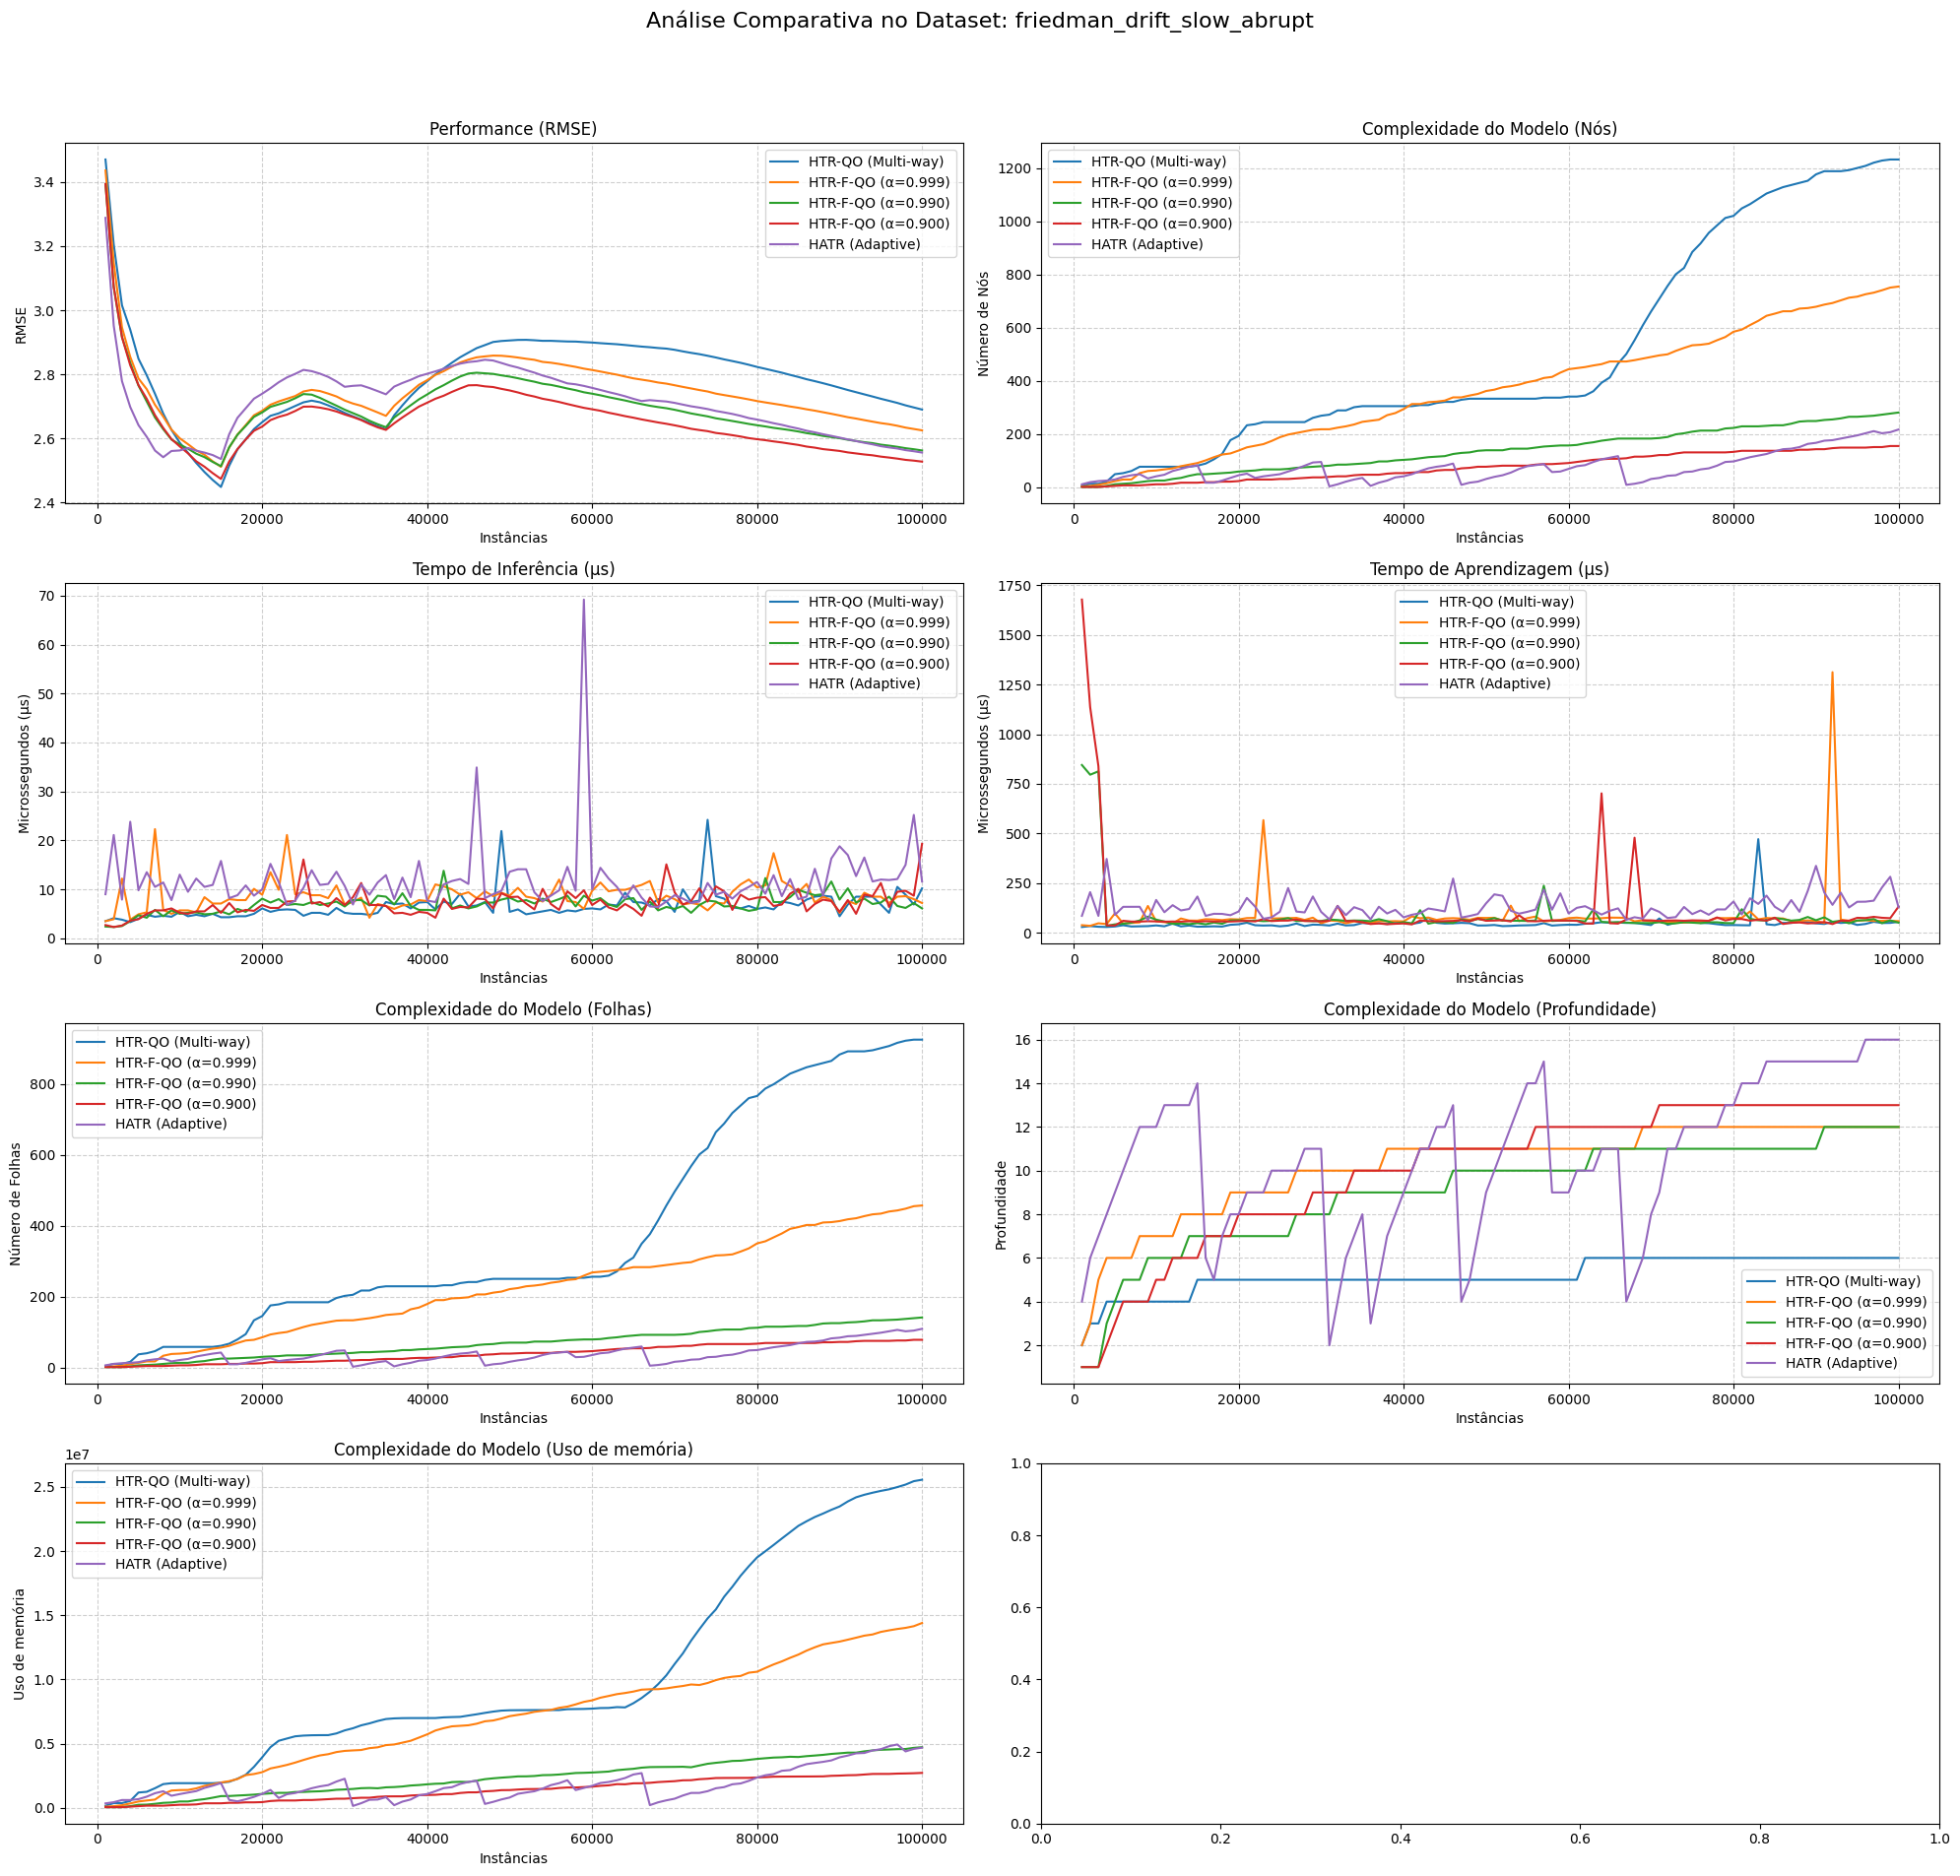

--------------------------------------------------


In [3]:
# --- Execução Principal ---
INSTANCES = 100000
dataset_factories = get_datasets()
models = get_models()

for d_name, dataset_factory in dataset_factories.items():
    print(f"--- Iniciando avaliação no dataset: {d_name.upper()} ---")

    # Cria uma figura com 4x2 subplots para as métricas
    fig, axes = plt.subplots(4, 2, figsize=(20, 20))
    fig.suptitle(f"Análise Comparativa no Dataset: {d_name}", fontsize=16)

    # Define os títulos para cada subplot
    ax_titles = [
        "Performance (RMSE)",
        "Complexidade do Modelo (Nós)",
        "Tempo de Inferência (μs)",
        "Tempo de Aprendizagem (μs)",
        "Complexidade do Modelo (Folhas)",
        "Complexidade do Modelo (Profundidade)",
        "Complexidade do Modelo (Uso de memória)",
    ]
    ax_ylabels = ["RMSE", "Número de Nós", "Microssegundos (μs)", "Microssegundos (μs)", "Número de Folhas", "Profundidade", "Uso de memória"]

    for model_name, model in models.items():
        print(f"\nAvaliando modelo: {model_name}")

        eval_model = model.clone()
        eval_dataset_stream = dataset_factory().take(INSTANCES)

        history = evaluate_and_plot_all_metrics(
            eval_dataset_stream, eval_model, RMSE(), print_every=INSTANCES // 100
        )

        # Plota cada métrica em seu respectivo subplot
        axes[0, 0].plot(history["steps"], history["performance"], label=model_name)
        axes[0, 1].plot(history["steps"], history["n_nodes"], label=model_name)
        axes[1, 0].plot(history["steps"], history["inference_time_us"], label=model_name)
        axes[1, 1].plot(history["steps"], history["learning_time_us"], label=model_name)
        axes[2, 0].plot(history["steps"], history["n_leaves"], label=model_name)
        axes[2, 1].plot(history["steps"], history["height"], label=model_name)
        axes[3, 0].plot(history["steps"], history["memory_usage"], label=model_name)


    # Configura os eixos e legendas para cada subplot
    for i, ax in enumerate(axes.flatten()):
        if i != 7:
            ax.set_title(ax_titles[i])
            ax.set_xlabel("Instâncias")
            ax.set_ylabel(ax_ylabels[i])
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout para o supertítulo
    plt.show()
    print("-" * 50)